# Set Up

## Importing Libraries

In [76]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [77]:
tf.__version__

'2.13.1'

In [78]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Extra

# Data Collection/Preprocessing

## Collecting Data

In [79]:
data = pd.read_csv("../outputs/training_metadata.csv")

In [80]:
data.head()

,path,left,right,forward,backward,brake
0,outputs/training_data/10.jpeg,1,0,1,0,0
1,outputs/training_data/11.jpeg,1,0,1,0,0
2,outputs/training_data/12.jpeg,1,0,1,0,0
3,outputs/training_data/13.jpeg,1,0,1,0,0
4,outputs/training_data/14.jpeg,1,0,1,0,0


## Analyzing Data

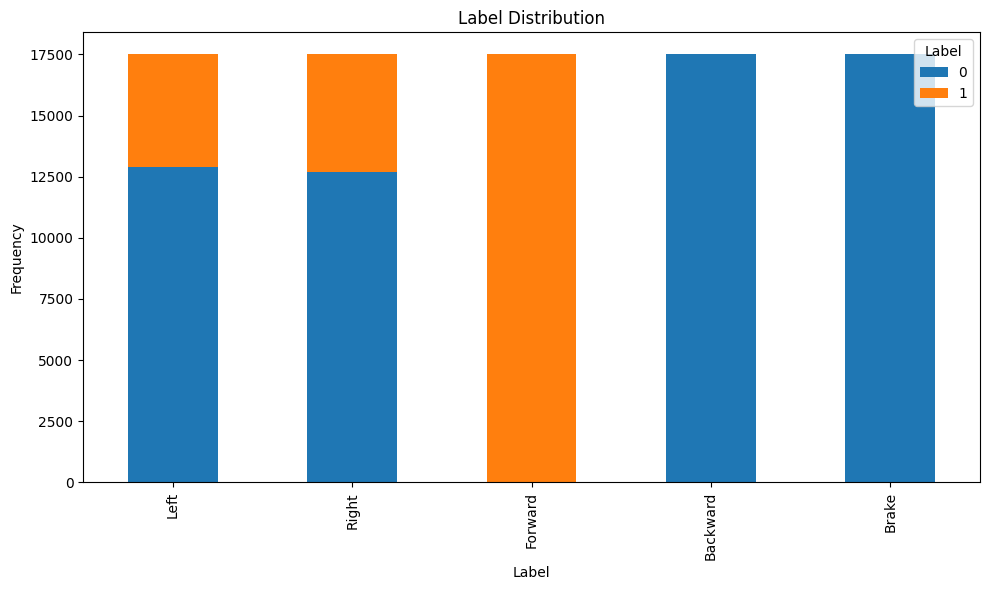

In [81]:
left_labels = data['left']
right_labels = data['right']
forward_labels = data['forward']
backward_labels = data['backward']
brake_labels = data['brake']

left_counts = left_labels.value_counts()
right_counts = right_labels.value_counts()
forward_counts = forward_labels.value_counts()
backward_counts = backward_labels.value_counts()
brake_counts = brake_labels.value_counts()

df = pd.DataFrame({
    'Left': left_counts,
    'Right': right_counts,
    'Forward': forward_counts,
    'Backward': backward_counts,
    'Brake': brake_counts
}).transpose()

# Plot the distribution of labels
fig, ax = plt.subplots(figsize=(10, 6))

df.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Label Distribution')
ax.set_xlabel('Label')
ax.set_ylabel('Frequency')
ax.legend(['0', '1'], title='Label')

plt.tight_layout()
plt.show()

## Preprocessing Data

In [82]:
def load_image(image_path):
    image = Image.open("../"+image_path)
    image = np.array(image)
    return image

In [83]:
data['path'][0]

'outputs/training_data/10.jpeg'

In [84]:
images = [load_image(image_path) for image_path in data['path']]
images = np.array(images)

In [85]:
images[0].shape

(64, 64)

In [86]:
# mean = np.mean(images, axis=(0, 1, 2))
# std = np.std(images, axis=(0, 1, 2))
# scaled_images = (images - mean) / std

In [87]:
targets = data[['left', 'right', 'forward', 'brake']].values

## Splitting Data

In [88]:
X_train, X_temp, y_train, y_temp = train_test_split(
    images, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [89]:
len(X_train)

14024

In [90]:
len(X_test)

1753

# Neural Network

## Model Set Up

In [91]:
optimizer = Adam(learning_rate=0.001)

In [92]:
model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation='relu', input_shape=(
        64, 64, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(40, activation='relu'),
    layers.Dropout(0.6),
    layers.Dense(4, activation='sigmoid')
])

In [93]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 62, 62, 128)       1280      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        36896     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 6272)              0         
                                                                 
 dense_4 (Dense)             (None, 40)               

## Training Model

In [94]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [95]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_val, y_val))

439/439 [==============================] - 53s 118ms/step - loss: 0.4789 - accuracy: 0.4586 - val_loss: 0.2126 - val_accuracy: 0.4712


## Testing Model

In [96]:
test_loss = model.evaluate(X_test, y_test)

55/55 [==============================] - 2s 28ms/step - loss: 0.2151 - accuracy: 0.4598


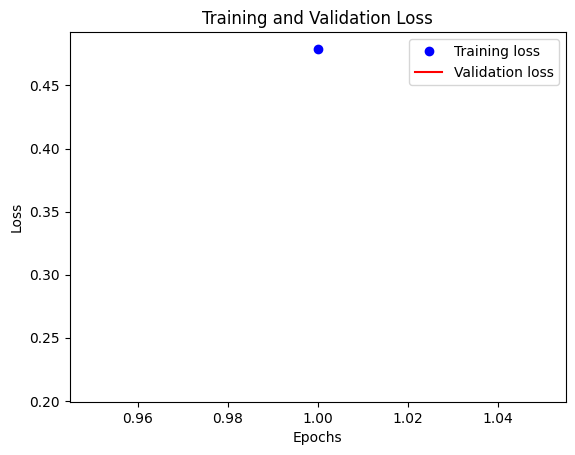

In [97]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

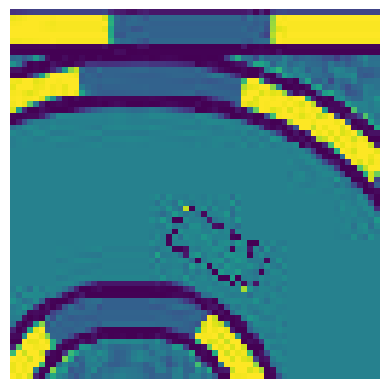

In [98]:
image = X_test[1]
plt.imshow(image)
plt.axis('off')
plt.show()

In [99]:
test_image = image.reshape(1, 64, 64, 1)
predictions = model.predict(test_image)
print(predictions)

1/1 [==============================] - 0s 59ms/step
[[0.34268606 0.33852407 0.98487496 0.00174059]]


## Prediction Distribution

In [100]:
predictions_list = []
for num in range(250):
    image = X_test[num]
    test_image = image.reshape(1, 64, 64, 1)
    prediction = model.predict(test_image)
    predictions_list.append(prediction)

1/1 [==============================] - 0s 15ms/step


In [101]:
predictions_list

[array([[1.0454159e-02, 5.6510355e-02, 9.9985737e-01, 8.7130640e-05]],
       dtype=float32),
 array([[0.34268606, 0.33852407, 0.98487496, 0.00174059]], dtype=float32),
 array([[1.1120974e-02, 5.2078851e-02, 9.9986041e-01, 7.7285644e-05]],
       dtype=float32),
 array([[0.45915908, 0.50987154, 0.96946365, 0.003588  ]], dtype=float32),
 array([[6.7925096e-02, 6.9251277e-02, 9.9850303e-01, 7.5336511e-04]],
       dtype=float32),
 array([[0.40750366, 0.68925273, 0.9683662 , 0.00439888]], dtype=float32),
 array([[0.22407462, 0.25036985, 0.98625803, 0.00912452]], dtype=float32),
 array([[0.46356833, 0.22402848, 0.9918033 , 0.01455866]], dtype=float32),
 array([[0.36453578, 0.05039929, 0.9799287 , 0.00351746]], dtype=float32),
 array([[0.5206108 , 0.05626613, 0.992696  , 0.00369908]], dtype=float32),
 array([[0.552639  , 0.28152502, 0.98697954, 0.02610763]], dtype=float32),
 array([[0.11258056, 0.13837655, 0.99405307, 0.00345696]], dtype=float32),
 array([[0.25968945, 0.23804304, 0.9565009 

1/1 [==============================] - 0s 31ms/step
128


ValueError: num must be an integer with 1 <= num <= 64, not 65

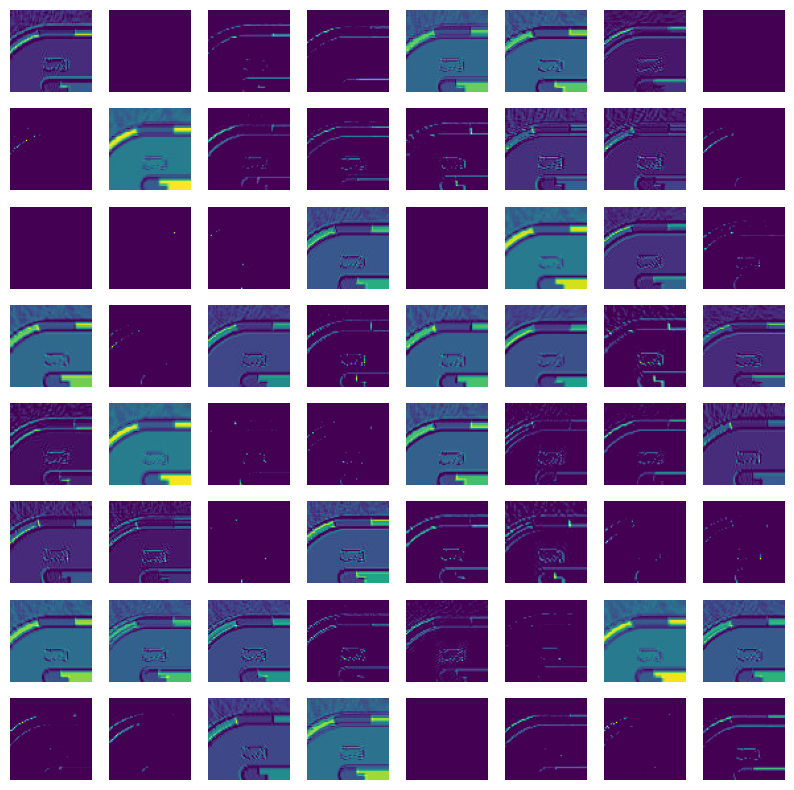

In [104]:
intermediate_layer_model = tf.keras.Model(inputs=model.input,
                                               outputs=model.get_layer('conv2d_4').output)
activations = intermediate_layer_model.predict(test_image.reshape(1, 64, 64, 1))

print(activations.shape[-1])

plt.figure(figsize=(10, 10))
for i in range(activations.shape[-1]):
    plt.subplot(8, 8, i+1)
    plt.imshow(activations[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

## Saving Model Weights

In [105]:
model.save("../models/CNN/CNN_steering_model_auto_gs_64_1epoch_sig_bc.h5")

c:\Users\andyx\Desktop\Projects\SelfDrivingCarSimulator\env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
